# 1. Projet Optimisation et Apprentissage

L'objectif de ce projet est d'implémenter les différents modèles de programmation linéaire en variables mixtes vus en cours pour les Support Vector Machine (SVM) pour la séparation de points en deux dimensions.

**Remarque :** Comme vu en cours, on utilisera la norme 1 dans la fonction objective pour les différents modèles.

## Attendu pour ce projet

1. Générer un dataset composé de 20 points 2D aléatoires. Chaque point aura un label parmi $\{-1,1\}$ de telle manière que :
      * chaque classe a le même nombre de points,
      * les points sont linéairement séparables. 
2. Implémenter le problème d'optimisation linéaire déterminant l'hyperplan optimal et donner l'équation de cet hyperplan.
3. Modifier le label de 5 points afin de rendre ce dataset non linéairement séparable.
4. Implémenter deux modèles vus en cours (selon les losses choisies : hinge, Ramp ou Hard margin) permettant d'obtenir les hyperplans optimaux. Donner les deux hyperplans obtenus.
5. Comparer et discuter les résultats obtenus par les différents modèles.

**Optionnel :** 
* Vous pouvez ajouter des figures (générées avec `mathplotlib` par exemple) pour illustrer les hyperplans obtenus.
* Vous pouvez évaluer l'impact de la variation de la pondération $C$ utilisée dans les losses.
* Vous pouvez tester sur un dataset plus important.

Le projet doit être un fichier notebook python contenant les modèles et les résultats. Des images/photos peuvent être insérées dans ce fichier. 
Ce dernier doit être envoyé par mail à **lacroix@lipn.fr** avant le **9 mars 2025**.



# 2. Génération du Dataset de de Test

In [2]:
import numpy as np

# Constantes
N_SAMPLES = 10

# Fixation la reproductibilité
np.random.seed(42)

# Génération des données
def generate_dataset(n_samples):

    x1 = np.random.randn(n_samples, 2) + np.array([2, 2]) 
    x2 = np.random.randn(n_samples, 2) + np.array([-2, -2])

    X = np.vstack((x1, x2))
    y = np.hstack((np.ones(N_SAMPLES), -np.ones(N_SAMPLES)))
    
    return X, y

X, y = generate_dataset(N_SAMPLES)   

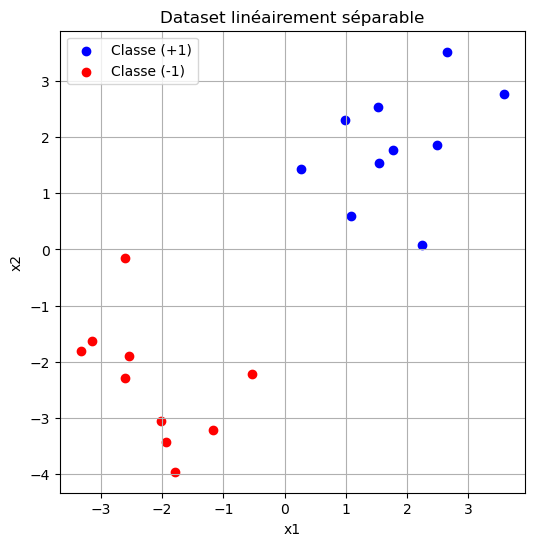

In [3]:
import matplotlib.pyplot as plt

# Affichage des graphiques de données
def plot_dataset(X, labels, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[labels == 1, 0], X[labels == 1, 1], color='blue', label="Classe (+1)")
    plt.scatter(X[labels == -1, 0], X[labels == -1, 1], color='red', label="Classe (-1)")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.title(title)
    plt.grid()
    plt.show()




plot_dataset(X, y, "Dataset linéairement séparable")

# 2. SVM à marge dure

Dans un SVM à marge dure, l'objectif est d'identifier un hyperplan qui sépare complètement les points de données appartenant à différentes classes, en garantissant une démarcation claire avec la plus grande largeur de marge possible. Cette marge est la distance entre l'hyperplan et le point de données le plus proche, également appelé vecteurs de support.

La fonction **hardsvm_model_optimisation** prends en entrées les données et les étiquettes associées. 

In [4]:
from mip import *

def hardsvm_model_optimisation(data, labels):

    m = Model("Hard SVM Solver", sense=MINIMIZE)
    
    # Variables de décision
    w1 = m.add_var(name="w1")      
    u1 = m.add_var(name="u1")      
    w2 = m.add_var(name="w2")      
    u2 = m.add_var(name="u2")      
    b = m.add_var(name="b", lb=float("-inf")) 
    
    # Contraintes pour définir u1 = |w1| et u2 = |w2|
    # La valeur absolue est définie n'est pas linéaire, nous devons donc ajouter des variables auxiliaires
    m += u1 >= w1
    m += u1 >= -w1
    m += u2 >= w2
    m += u2 >= -w2
    
    # Contraintes de séparation
    for (x1, x2), label in zip(data, labels):
        m += label * (w1 * x1 + w2 * x2 + b) >= 1
    
    # Minimisation de la norme L1 de w
    m.objective = minimize(u1 + u2)    
    m.optimize()    
    
    print(f"\nSolution trouvée :")
    print(f"w1 = {w1.x}, w2 = {w2.x}, b = {b.x}")

    print(f"Equation de la droite séparatrice {w1.x}.x1 + {w2.x}.x2 + {b.x} = 0")
    
    return w1.x, w2.x, b.x

# Trouver la ligne de séparation optimale
w1_hardsvm_opt, w2_hardsvm_opt, b_hardsvm_opt = hardsvm_model_optimisation(X, y)

Welcome to the CBC MILP Solver 
Version: devel 
Build Date: Feb 11 2025
Starting solution of the Linear programming problem using Dual Simplex

Coin0506I Presolve 22 (-2) rows, 5 (0) columns and 64 (-4) elements
Clp0000I Optimal - objective value 0.90156371
Coin0511I After Postsolve, objective 0.90156371, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 0.9015637148 - 8 iterations time 0.002, Presolve 0.00

Solution trouvée :
w1 = 0.45194530375472003, w2 = 0.4496184110905334, b = 0.2422475331091788
Equation de la droite séparatrice 0.45194530375472003.x1 + 0.4496184110905334.x2 + 0.2422475331091788 = 0


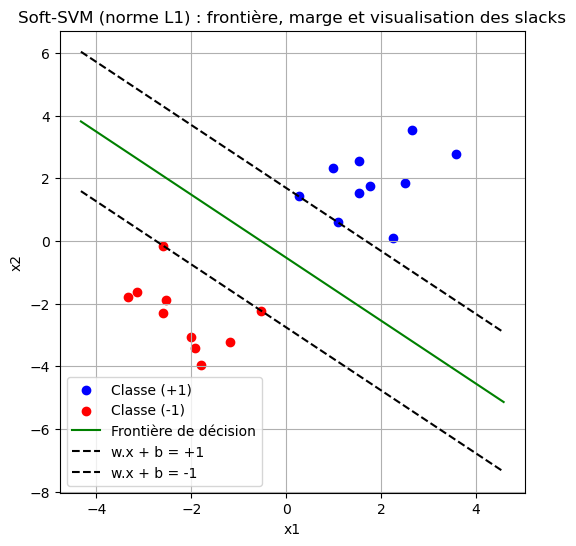

In [6]:
def plot_data_and_slack_lines(X, labels, w1, w2, b):
    """
    X       : np.array shape (n,2) les coordonnées des points
    labels  : np.array shape (n,)   étiquettes (+1 ou -1)
    w1, w2  : flottants, paramètres du séparateur
    b       : flottant, biais
    slacks  : liste ou tableau des xi_i (même ordre que X)
    
    Affiche :
      - Les points (rouge pour -1, bleu pour +1)
      - La frontière de décision w1*x + w2*y + b = 0 (vert)
      - Les marges w.x + b = ±1 (pointillées noires)
      - Pour chaque point ayant xi_i > 0, un segment orange jusqu'à la marge correspondante
    """
    plt.figure(figsize=(6, 6))
    
    # Affichage points
    plt.scatter(X[labels == 1, 0], X[labels == 1, 1], c='blue', label="Classe (+1)")
    plt.scatter(X[labels == -1, 0], X[labels == -1, 1], c='red',  label="Classe (-1)")

    # On définit un "range" pour x en s'adaptant aux données
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x_vals = np.linspace(x_min, x_max, 300)

    # Pour éviter la division par zéro si w2 est ~ 0
    if abs(w2) > 1e-8:
        # Droite de décision:  w1*x + w2*y + b = 0 => y = -(w1*x + b)/w2
        y_decision = -(w1 * x_vals + b) / w2
        
        # Marges: w.x + b = +1 => y = -(w1*x + (b - 1)) / w2
        y_plus  = -(w1 * x_vals + (b - 1)) / w2
        #         w.x + b = -1 => y = -(w1*x + (b + 1)) / w2
        y_minus = -(w1 * x_vals + (b + 1)) / w2

        # Tracés
        plt.plot(x_vals, y_decision, 'g-',  label='Frontière de décision')
        plt.plot(x_vals, y_plus,     'k--', label='w.x + b = +1')
        plt.plot(x_vals, y_minus,    'k--', label='w.x + b = -1')
    else:
        # Cas frontière quasi verticale: x = -b/w1
        x_decision = -b / w1
        x_plus     = -(b - 1) / w1
        x_minus    = -(b + 1) / w1

        plt.axvline(x=x_decision, color='g', label='Frontière de décision')
        plt.axvline(x=x_plus,     color='k', linestyle='--', label='w.x + b = +1')
        plt.axvline(x=x_minus,    color='k', linestyle='--', label='w.x + b = -1')

    # Légendes et affichage
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("Soft-SVM (norme L1) : frontière, marge et visualisation des slacks")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_data_and_slack_lines(X, y, w1_hardsvm_opt, w2_hardsvm_opt, b_hardsvm_opt)   

# 3. Modification de labels afin de rendre ce dataset non linéairement séparable

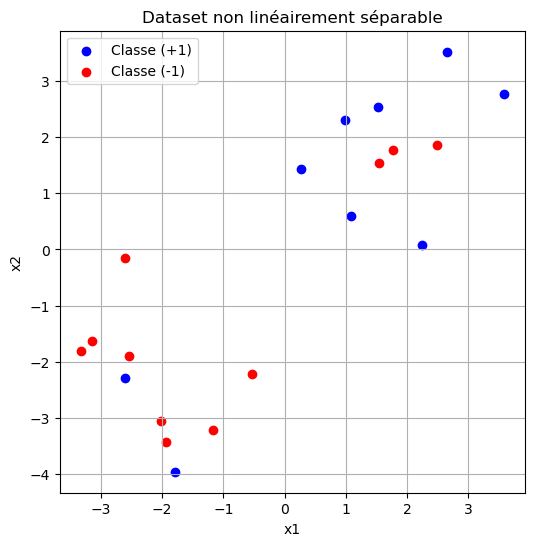

In [7]:
def modification_label(y):
    # Modification du label de 5 points pour rendre le dataset non linéairement séparable
    y_flipped = y.copy()
    flip_indices = np.random.choice(2 * N_SAMPLES, 5, replace=False)
    y_flipped[flip_indices] *= -1
    return y_flipped

y_flipped = modification_label(y)

plot_dataset(X, y_flipped, "Dataset non linéairement séparable")

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from matplotlib.animation import FuncAnimation


# Définition des valeurs de C à tester
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Stocker les modèles entraînés
models = []
for C in C_values:
    model = SVC(kernel='linear', C=C)
    model.fit(X, y_flipped)

    w = model.coef_[0]
    b = model.intercept_[0]
    
    # Calcul de la frontière de décision : y = (-w1/w2) * x - (b/w2)
    print(f"Modèle entraîné avec C={C} : w1={w[0]}, w2={w[1]}, b={b}")

    models.append((C, model))



Modèle entraîné avec C=0.001 : w1=0.014185084488371087, w2=0.01401159971137466, b=-0.928059744000435
Modèle entraîné avec C=0.01 : w1=0.14185084488371086, w2=0.14011599711374662, b=-0.2805974400043487
Modèle entraîné avec C=0.1 : w1=0.23191717657800773, w2=0.2380517145279204, b=0.03978914840398092
Modèle entraîné avec C=1 : w1=0.23191714741534297, w2=0.23805188364731844, b=0.039788684577202825
Modèle entraîné avec C=10 : w1=0.2319168557995801, w2=0.23805357483128908, b=0.03978404630880542
Modèle entraîné avec C=100 : w1=0.23191393968795548, w2=0.23807048662862584, b=0.03973766362228185


In [12]:
from mip import Model, xsum, minimize, BINARY

def svmsoft_with_hinge_loss_model_optimisation(data, labels, C=1.0):
    """
    data   : liste des points (x1, x2)
    labels : liste des étiquettes correspondantes (+1 ou -1)
    C      : hyperparamètre pour pondérer la somme des slack variables
    """
    
    # Création du modèle
    m = Model("Soft SVM Solver", sense=minimize)
    m.verbose = 0
    
    # Variables pour les coefficients w1, w2, et le biais b
    w1 = m.add_var(name="w1", lb=float("-inf"))
    w2 = m.add_var(name="w2", lb=float("-inf"))
    b = m.add_var(name="b",  lb=float("-inf"))
    
    # Variables auxiliaires u1, u2 pour modéliser la norme L1 de (w1, w2)
    u1 = m.add_var(name="u1", lb=0.0)
    u2 = m.add_var(name="u2", lb=0.0)
    
    # Contraintes pour définir u1 = |w1| et u2 = |w2|
    m += u1 >= w1
    m += u1 >= -w1
    m += u2 >= w2
    m += u2 >= -w2
    
    # Liste/ensemble des variables de slack, une par point
    xi = []
    
    # Ajout des contraintes de séparation "souple" : y_i(w.x_i + b) >= 1 - xi_i
    for i, ((x1_i, x2_i), label_i) in enumerate(zip(data, labels)):
        # Variable slack pour ce point
        xi_i = m.add_var(name=f"xi_{i}", lb=0.0)
        xi.append(xi_i)
        
        # Contrainte hinge : y_i * (w1*x1_i + w2*x2_i + b) >= 1 - xi_i
        m += label_i * (w1 * x1_i + w2 * x2_i + b) >= 1 - xi_i
    
    # Fonction objectif : minimiser ||w||_1 + C * Σ xi_i
    # où ||w||_1 = u1 + u2
    m.objective = minimize(u1 + u2 + C * xsum(xi))
    
    # Lancement de l'optimisation
    m.optimize()
    
    print("Solution trouvée :")
    print(f"C={C}, w1 = {w1.x}, w2 = {w2.x}, b = {b.x}")
    #print("Slack variables :")
    #for i, xi_i in enumerate(xi):
    #    print(f"  xi_{i} = {xi_i.x}")
    
    return w1.x, w2.x, b.x, [xi_i.x for xi_i in xi]


    
w1_softsvm_hinge_opt, w2_softsvm_hinge_opt, b_softsvm_hinge_opt, slack_softsvm_hinge = svmsoft_with_hinge_loss_model_optimisation(X, y_flipped, C=0.1)

Solution trouvée :
C=0.1, w1 = 0.1957844850613288, w2 = 0.15536678356075206, b = -0.1307217705918315


In [15]:
def plot_data_and_details(title, X, labels, w1, w2, b, slacks):
    """
    X       : np.array shape (n,2) les coordonnées des points
    labels  : np.array shape (n,)   étiquettes (+1 ou -1)
    w1, w2  : flottants, paramètres du séparateur
    b       : flottant, biais
    slacks  : liste ou tableau des xi_i (même ordre que X)
    
    Affiche :
      - Les points (rouge pour -1, bleu pour +1)
      - La frontière de décision w1*x + w2*y + b = 0 (vert)
      - Les marges w.x + b = ±1 (pointillées noires)
      - Pour chaque point ayant xi_i > 0, un segment orange jusqu'à la marge correspondante
    """
    plt.figure(figsize=(6, 6))
    
    # Affichage points
    plt.scatter(X[labels == 1, 0], X[labels == 1, 1], c='blue', label="Classe (+1)")
    plt.scatter(X[labels == -1, 0], X[labels == -1, 1], c='red',  label="Classe (-1)")

    # On définit un "range" pour x en s'adaptant aux données
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x_vals = np.linspace(x_min, x_max, 300)

    # Pour éviter la division par zéro si w2 est ~ 0
    if abs(w2) > 1e-8:
        # Droite de décision:  w1*x + w2*y + b = 0 => y = -(w1*x + b)/w2
        y_decision = -(w1 * x_vals + b) / w2
        
        # Marges: w.x + b = +1 => y = -(w1*x + (b - 1)) / w2
        y_plus  = -(w1 * x_vals + (b - 1)) / w2
        #         w.x + b = -1 => y = -(w1*x + (b + 1)) / w2
        y_minus = -(w1 * x_vals + (b + 1)) / w2

        # Tracés
        plt.plot(x_vals, y_decision, 'g-',  label='Frontière de décision')
        plt.plot(x_vals, y_plus,     'k--', label='w.x + b = +1')
        plt.plot(x_vals, y_minus,    'k--', label='w.x + b = -1')
    else:
        # Cas frontière quasi verticale: x = -b/w1
        x_decision = -b / w1
        x_plus     = -(b - 1) / w1
        x_minus    = -(b + 1) / w1

        plt.axvline(x=x_decision, color='g', label='Frontière de décision')
        plt.axvline(x=x_plus,     color='k', linestyle='--', label='w.x + b = +1')
        plt.axvline(x=x_minus,    color='k', linestyle='--', label='w.x + b = -1')

    # --------------- Trace des segments pour les slacks > 0 ---------------
    # Normal au séparateur = w = (w1, w2)
    if slacks is not None:
        w = np.array([w1, w2], dtype=float)
        w_norm_squared = w1**2 + w2**2
        
        for i, (pt, lab, xi) in enumerate(zip(X, labels, slacks)):
            if xi > 1e-9:
                # Étiquette = +1 => marge = +1 ;  -1 => marge = -1
                alpha = 1.0 if lab == 1 else -1.0
                
                # On veut la projection de pt sur la droite w.x + b = alpha
                # pt^* = pt + delta * w,  où  delta * (w.w) = alpha - b - w.pt
                # => delta = (alpha - b - w·pt) / ||w||^2
                w_dot_pt = w1 * pt[0] + w2 * pt[1]
                delta = (alpha - b - w_dot_pt) / w_norm_squared

                # Intersection
                pt_star = pt + delta * w

                # Tracé d'un segment de pt => pt_star en orange
                #   zorder=3 pour être au-dessus
                plt.plot([pt[0], pt_star[0]],
                        [pt[1], pt_star[1]],
                        color='orange', linewidth=1.5, alpha=0.8, zorder=3)

    # Légendes et affichage
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("Soft-SVM (norme L1) : frontière, marge et visualisation des slacks")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_data_and_details(X, y_flipped, w1_softsvm_hinge_opt, w2_softsvm_hinge_opt, b_softsvm_hinge_opt, slack_softsvm_hinge)

TypeError: plot_data_and_details() missing 1 required positional argument: 'slacks'

In [16]:
C_candidates = [0.001, 0.01, 0.1, 1, 10, 100]

for c in C_candidates:
    #print(f"=== Test avec C={c} ===")
    w1_opt, w2_opt, b_opt, slack_opt = svmsoft_with_hinge_loss_model_optimisation(X, y_flipped, C=c)
    #plot_data_and_slack_lines(X, y_flipped, w1_opt, w2_opt, b_opt, slack_opt)

Solution trouvée :
C=0.001, w1 = 0.0, w2 = 0.0, b = -0.9999999999999999
Solution trouvée :
C=0.01, w1 = 0.0, w2 = 0.0, b = -0.9999999999999999
Solution trouvée :
C=0.1, w1 = 0.1957844850613288, w2 = 0.15536678356075206, b = -0.1307217705918315
Solution trouvée :
C=1, w1 = 0.23192304166943725, w2 = 0.238046292046591, b = 0.03978885355159321
Solution trouvée :
C=10, w1 = 0.23192304166943725, w2 = 0.238046292046591, b = 0.03978885355159321
Solution trouvée :
C=100, w1 = 0.23192304166943725, w2 = 0.238046292046591, b = 0.03978885355159321
